**Table of contents**<a id='toc0_'></a>    
- [Import and reading data](#toc1_1_)    
  - [Separating Explanatory and Response Variables](#toc1_2_)    
  - [Variables investigation:](#toc1_3_)    
    - [Variable types](#toc1_3_1_)    
    - [Investigation of NA values;](#toc1_3_2_)    
  - [Scaling of variables](#toc1_4_)    
  - [Zero variance filter](#toc1_5_)    
  - [k-Nearest Neighbor (Imputation of NaN values)](#toc1_6_)    
  - [Descale Data](#toc1_7_)    
  - [Re-join response and explanatory variables](#toc1_8_)    
  - [Saving final data](#toc1_9_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Import and reading data](#toc0_)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

In [2]:
drugs = pd.read_csv('../../../../data/fda_approved_datasets/fda_approved_with_descriptors/fda_approved_rdkit.csv', 
low_memory=False)
print(drugs.shape)
drugs.head()

(1895, 222)


,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## <a id='toc1_2_'></a>[Separating Explanatory and Response Variables](#toc0_)

As the topic title says, we must separate the explanatory and response variables, here we have the `response_variables` that has most flags, `name`, `chembl_id` and the `clean_smiles`.

In [3]:
# Removing flag columns
flag_columns = [
    'name',
    'chembl_id',
    'clean_smiles',
    'first_approval_year',
    'indication_class',
    'molecule_type',
    'withdrawn_flag',
    'therapeutic_flag',
    'polymer_flag',
    'inorganic_flag',
    'natural_product_flag',
    'parenteral',
    'topical',
    'oral',
]

drugs_features = drugs.drop(labels=flag_columns, axis=1)
print(drugs_features.shape)
drugs_features.head()

(1895, 208)


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,6.055556,-0.333333,6.055556,0.333333,0.242956,59.072,54.032,59.048347,24.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.451389,-0.439815,9.451389,0.439815,0.301333,75.067,70.027,75.032028,30.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.229167,-0.939815,9.229167,0.939815,0.256644,76.055,72.023,76.027277,30.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4.951389,0.683642,4.951389,0.683642,0.419021,77.152,70.096,77.029920,26.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.555556,-0.611111,9.555556,0.611111,0.373753,78.136,72.088,78.013936,26.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
response_variables = drugs[flag_columns]
print(response_variables.shape)
response_variables.head()
# We could store the 'oral' cases into a pd.Series response variable
# oral_response = response_variables['oral']

(1895, 14)


,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,natural_product_flag,parenteral,topical,oral
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,False,False,False,True
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,False,False,False,True
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,False,False,False,True
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,False,True,False,False,False,False,True,True
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,False,True,False,False,False,True,False,False


In [5]:
explanatory_variables = drugs_features.copy()
explanatory_variables.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,6.055556,-0.333333,6.055556,0.333333,0.242956,59.072,54.032,59.048347,24.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.451389,-0.439815,9.451389,0.439815,0.301333,75.067,70.027,75.032028,30.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.229167,-0.939815,9.229167,0.939815,0.256644,76.055,72.023,76.027277,30.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4.951389,0.683642,4.951389,0.683642,0.419021,77.152,70.096,77.029920,26.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.555556,-0.611111,9.555556,0.611111,0.373753,78.136,72.088,78.013936,26.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## <a id='toc1_3_'></a>[Variables investigation:](#toc0_)

### <a id='toc1_3_1_'></a>[Variable types](#toc0_)

Checking each column type, we can see that everything is already on `float` type. That's excelent news,** we don't need to process** any column.

In [6]:
explanatory_variables.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1895 entries, 0 to 1894
Columns: 208 entries, MaxEStateIndex to fr_urea
dtypes: float64(208)
memory usage: 3.0 MB


### <a id='toc1_3_2_'></a>[Investigation of NA values;](#toc0_)

We can use the `seaborn` heatmap to plot the NA values on the dataset.

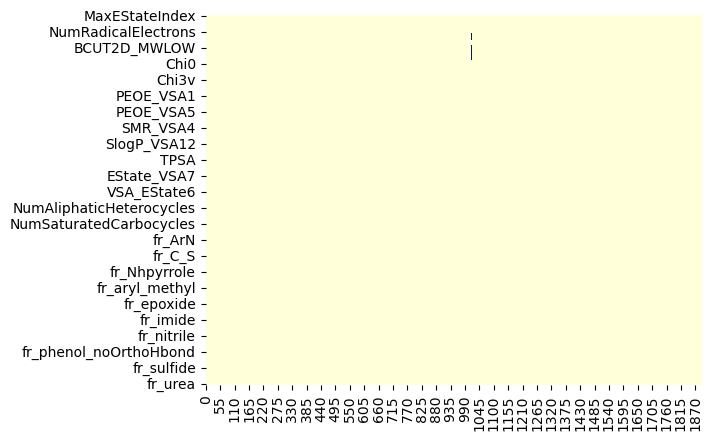

In [7]:
na_heatmap = sns.heatmap(explanatory_variables.isna().transpose(), cmap='YlGnBu', cbar=False)

In [8]:
print(f'In fact, there are {explanatory_variables.isna().sum().sum()} NaN Values.') 
print(f'Also, we have {explanatory_variables[explanatory_variables.isna().any(axis=1)].shape[0]} rows that have at least one NaN Value')

In fact, there are 108 NaN Values.
Also, we have 9 rows that have at least one NaN Value


In [9]:
response_variables.iloc[explanatory_variables[explanatory_variables.isna().any(axis=1)].index][['clean_smiles', 'name']]

,clean_smiles,name
491,CC(=O)Nc1cc([As](=O)(O)O)ccc1O,ACETARSONE
1015,O=C1O[Bi](O)Oc2ccccc21,BISMUTH SUBSALICYLATE
1131,CC[Hg]Sc1ccccc1C(=O)O,THIMEROSAL
1176,OC[C@H]1O[C@H](S[Au])[C@H](O)[C@@H](O)[C@@H]1O,AUROTHIOGLUCOSE
1193,O=C(O)c1cc(O)c2c(c1)O[Bi](O)O2,BISMUTH SUBGALLATE
1551,COC(CNC(=O)c1ccccc1OCC(=O)O)C[Hg]O,MERSALYL
1799,O=C(O)[C@@H]1O[Sb]2(O)(O[Sb]34(O)O[C@H]([C@H](...,SODIUM STIBOGLUCONATE
1809,O=C(O)c1ccccc1-c1c2cc(Br)c(=O)cc-2oc2c([Hg]O)c...,MERBROMIN
1873,O=S(=O)(O[Hg]c1ccccc1)c1cc2ccccc2cc1Cc1cc2cccc...,HYDRARGAPHEN


As expected, all the SMILES have some transition elements on the structure, specially `Hg`, `Bi` and `As`. Probably these descriptors cannot compute transition metals.

In [10]:
response_variables.loc[response_variables['clean_smiles'].str.contains('Hg')]

,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,natural_product_flag,parenteral,topical,oral
1131,THIMEROSAL,CHEMBL508338,CC[Hg]Sc1ccccc1C(=O)O,1927.0,Preservative,Small molecule,False,True,False,False,False,False,False,False
1551,MERSALYL,CHEMBL1200943,COC(CNC(=O)c1ccccc1OCC(=O)O)C[Hg]O,not found,NaN,Small molecule,False,True,False,False,False,True,False,False
1809,MERBROMIN,CHEMBL3833381,O=C(O)c1ccccc1-c1c2cc(Br)c(=O)cc-2oc2c([Hg]O)c...,not found,NaN,Small molecule,False,True,False,False,False,False,False,False
1873,HYDRARGAPHEN,CHEMBL3833364,O=S(=O)(O[Hg]c1ccccc1)c1cc2ccccc2cc1Cc1cc2cccc...,not found,NaN,Small molecule,False,True,False,False,False,False,False,False


There are some columns that have NA, so we should do some KNN imputation;

 But first, we need to remove feature with low variance (essentially variance == 0).

## <a id='toc1_4_'></a>[Scaling of variables](#toc0_)

Scaling is necessary so every variable is on the same scale and are comparable to each other. Non-parametric imputation as kNN are very sensible to the scale of the variables, so this is mandatory step.

In [11]:
scaler = StandardScaler()
scaled_data_array = scaler.fit_transform(explanatory_variables)

# Merging the column name with the scale data array
scaled_explanatory_variables = pd.DataFrame(scaled_data_array, columns=explanatory_variables.columns)
print(scaled_explanatory_variables.shape)
scaled_explanatory_variables.head()

(1895, 208)


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-1.906275,0.582326,-1.906275,0.541758,-1.452885,-1.829344,-1.834696,-1.828642,-1.762684,-0.022978,...,-0.249707,-0.249106,-0.115624,-0.110844,-0.115624,-0.148142,0.0,-0.14063,-0.194625,-0.206758
1,-0.701297,0.510259,-0.701297,0.953197,-1.186490,-1.737436,-1.736529,-1.736728,-1.672781,-0.022978,...,-0.249707,-0.249106,-0.115624,-0.110844,-0.115624,-0.148142,0.0,-0.14063,-0.194625,-0.206758
2,-0.780150,0.171862,-0.780150,2.885176,-1.390422,-1.731759,-1.724279,-1.731005,-1.672781,-0.022978,...,-0.249707,-0.249106,-0.115624,-0.110844,-0.115624,-0.148142,0.0,-0.14063,-0.194625,4.402733
3,-2.298078,1.270609,-2.298078,1.895335,-0.649441,-1.725456,-1.736105,-1.725239,-1.732716,-0.022978,...,-0.249707,-0.249106,-0.115624,-0.110844,-0.115624,-0.148142,0.0,-0.14063,-0.194625,-0.206758
4,-0.664334,0.394327,-0.664334,1.615079,-0.856015,-1.719802,-1.723880,-1.719581,-1.732716,-0.022978,...,-0.249707,-0.249106,-0.115624,-0.110844,-0.115624,-0.148142,0.0,-0.14063,-0.194625,-0.206758


## <a id='toc1_5_'></a>[Zero variance filter](#toc0_)

Removing the variables with a variance below a threshold. When the data is scale, the variance present is only either 1 or 0. This function will only remove feature with variance equals zero.


In [12]:
#  Function to retrieve the dataset with non-zero variance descriptors
def get_non_zero_var(data:pd.DataFrame) -> pd.DataFrame:
    """
    Recieves A SCALED dataframe and returns the non-zero variance dataframe
    """
    selector = VarianceThreshold()
    selector.fit(data)
    
    return data[data.columns[selector.get_support(indices=True)]]

In [13]:
# Zero variance filter over the scaled data
explanatory_variables_filter_var = get_non_zero_var(scaled_explanatory_variables)
explanatory_variables_filter_var

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-1.906275,0.582326,-1.906275,0.541758,-1.452885,-1.829344,-1.834696,-1.828642,-1.762684,-0.022978,...,-0.173263,-0.249707,-0.249106,-0.115624,-0.110844,-0.115624,-0.148142,-0.14063,-0.194625,-0.206758
1,-0.701297,0.510259,-0.701297,0.953197,-1.186490,-1.737436,-1.736529,-1.736728,-1.672781,-0.022978,...,-0.173263,-0.249707,-0.249106,-0.115624,-0.110844,-0.115624,-0.148142,-0.14063,-0.194625,-0.206758
2,-0.780150,0.171862,-0.780150,2.885176,-1.390422,-1.731759,-1.724279,-1.731005,-1.672781,-0.022978,...,-0.173263,-0.249707,-0.249106,-0.115624,-0.110844,-0.115624,-0.148142,-0.14063,-0.194625,4.402733
3,-2.298078,1.270609,-2.298078,1.895335,-0.649441,-1.725456,-1.736105,-1.725239,-1.732716,-0.022978,...,-0.173263,-0.249707,-0.249106,-0.115624,-0.110844,-0.115624,-0.148142,-0.14063,-0.194625,-0.206758
4,-0.664334,0.394327,-0.664334,1.615079,-0.856015,-1.719802,-1.723880,-1.719581,-1.732716,-0.022978,...,-0.173263,-0.249707,-0.249106,-0.115624,-0.110844,-0.115624,-0.148142,-0.14063,-0.194625,-0.206758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,1.331756,-0.681068,1.331756,-0.725934,-2.492999,5.965164,6.001906,5.965983,5.849102,-0.022978,...,-0.173263,-0.249707,-0.249106,-0.115624,-0.110844,-0.115624,11.310221,-0.14063,0.336808,-0.206758
1891,1.628522,-0.779293,1.628522,-0.369372,-2.222294,6.158777,6.264381,6.155242,5.998941,-0.022978,...,-0.173263,-0.249707,-0.249106,-0.115624,-0.110844,-0.115624,-0.148142,-0.14063,-0.194625,-0.206758
1892,1.237322,-2.422955,1.237322,-0.418866,-2.470768,7.254349,7.218039,7.254724,7.167680,-0.022978,...,-0.173263,-0.249707,-0.249106,-0.115624,-0.110844,-0.115624,-0.148142,-0.14063,2.993973,-0.206758
1893,1.741280,-2.471927,1.741280,-0.272585,-2.455682,7.919285,7.953004,7.916086,7.797000,-0.022978,...,-0.173263,-0.249707,-0.249106,-0.115624,-0.110844,-0.115624,-0.148142,-0.14063,5.119706,-0.206758


## <a id='toc1_6_'></a>[k-Nearest Neighbor (Imputation of NaN values)](#toc0_)

Using the k-NN method to fill-in the NaN values. We have only 109 NaN values, a small number compared to the total descriptor matrix.

In [14]:
print(f'Number of NaN values x all values, respectively: {explanatory_variables_filter_var.isna().sum().sum()} vs  {explanatory_variables_filter_var.shape[0]*explanatory_variables_filter_var.shape[1]}')

Number of NaN values x all values, respectively: 108 vs  380895


In [15]:
selector = KNNImputer(n_neighbors=5)
explanatory_variables_fill_na = selector.fit_transform(explanatory_variables_filter_var)

In [16]:
explanatory_variables_no_na = pd.DataFrame(explanatory_variables_fill_na, columns=explanatory_variables_filter_var.columns)
print(explanatory_variables_no_na.shape)
explanatory_variables_no_na.head()

(1895, 201)


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-1.906275,0.582326,-1.906275,0.541758,-1.452885,-1.829344,-1.834696,-1.828642,-1.762684,-0.022978,...,-0.173263,-0.249707,-0.249106,-0.115624,-0.110844,-0.115624,-0.148142,-0.14063,-0.194625,-0.206758
1,-0.701297,0.510259,-0.701297,0.953197,-1.186490,-1.737436,-1.736529,-1.736728,-1.672781,-0.022978,...,-0.173263,-0.249707,-0.249106,-0.115624,-0.110844,-0.115624,-0.148142,-0.14063,-0.194625,-0.206758
2,-0.780150,0.171862,-0.780150,2.885176,-1.390422,-1.731759,-1.724279,-1.731005,-1.672781,-0.022978,...,-0.173263,-0.249707,-0.249106,-0.115624,-0.110844,-0.115624,-0.148142,-0.14063,-0.194625,4.402733
3,-2.298078,1.270609,-2.298078,1.895335,-0.649441,-1.725456,-1.736105,-1.725239,-1.732716,-0.022978,...,-0.173263,-0.249707,-0.249106,-0.115624,-0.110844,-0.115624,-0.148142,-0.14063,-0.194625,-0.206758
4,-0.664334,0.394327,-0.664334,1.615079,-0.856015,-1.719802,-1.723880,-1.719581,-1.732716,-0.022978,...,-0.173263,-0.249707,-0.249106,-0.115624,-0.110844,-0.115624,-0.148142,-0.14063,-0.194625,-0.206758


Number of NaN values: 0


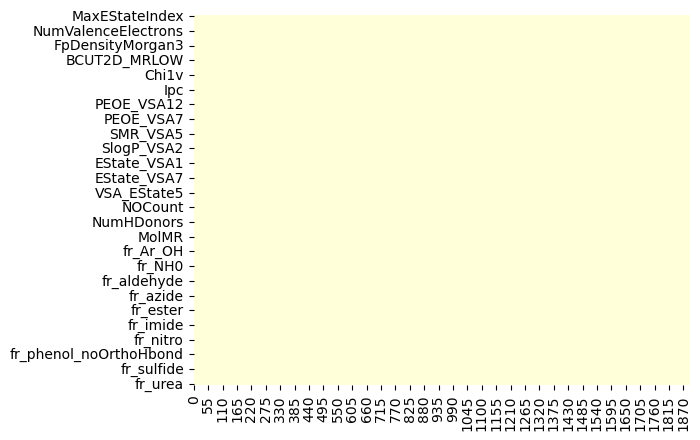

In [17]:
# Checking the number of NaN values after the imputation
print(f'Number of NaN values: {explanatory_variables_no_na.isna().sum().sum()}')
g = sns.heatmap(explanatory_variables_no_na.isna().transpose(), cmap='YlGnBu', cbar=False)

## <a id='toc1_7_'></a>[Descale Data](#toc0_)

Restoring original descriptor data before saving for **mainly two reasons**: 

* Some models employ scaled data (kNN, Naive Bayes) and some do not (DT, RF and all the boosted ensembles). 
* For the models that need to use the scaled data, the scaling process needs to be done separatedly for the **traning** and **test groups**.

In [18]:
# creating a temporary dataset and descaling it
drugs_scale = explanatory_variables[explanatory_variables_no_na.columns].copy()
descaler = StandardScaler()
_ = descaler.fit_transform(drugs_scale)

print(f'Checking both if both of the dataframes have the same info\
      {drugs_scale.shape} x {explanatory_variables_no_na.shape}')

Checking both if both of the dataframes have the same info      (1895, 201) x (1895, 201)


In [19]:
# proper descale of data
explanatory_variables_descaled = descaler.inverse_transform(explanatory_variables_no_na)

explanatory_variables_descaled = pd.DataFrame(explanatory_variables_descaled, columns=explanatory_variables_no_na.columns)
print(explanatory_variables_no_na.shape)
explanatory_variables_descaled

(1895, 201)


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,6.055556,-0.333333,6.055556,0.333333,0.242956,59.072,54.032,59.048347,24.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.451389,-0.439815,9.451389,0.439815,0.301333,75.067,70.027,75.032028,30.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.229167,-0.939815,9.229167,0.939815,0.256644,76.055,72.023,76.027277,30.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4.951389,0.683642,4.951389,0.683642,0.419021,77.152,70.096,77.029920,26.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.555556,-0.611111,9.555556,0.611111,0.373753,78.136,72.088,78.013936,26.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,15.180875,-2.200064,15.180875,0.005252,0.015026,1415.576,1330.904,1414.518432,532.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0
1891,16.017214,-2.345198,16.017214,0.097531,0.074348,1449.271,1373.671,1447.430200,542.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1892,14.914746,-4.773796,14.914746,0.084722,0.019898,1639.937,1529.057,1638.627902,620.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0
1893,16.334985,-4.846154,16.334985,0.122580,0.023203,1755.658,1648.810,1753.637429,662.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0


Finally double checking the descaled data. It should contain the same computation for each descriptors, since we only have done the imputation and pre-selection of variables.

In [20]:
explanatory_variables_descaled[['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt']]

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt
0,6.055556,-0.333333,6.055556,0.333333,0.242956,59.072
1,9.451389,-0.439815,9.451389,0.439815,0.301333,75.067
2,9.229167,-0.939815,9.229167,0.939815,0.256644,76.055
3,4.951389,0.683642,4.951389,0.683642,0.419021,77.152
4,9.555556,-0.611111,9.555556,0.611111,0.373753,78.136
...,...,...,...,...,...,...
1890,15.180875,-2.200064,15.180875,0.005252,0.015026,1415.576
1891,16.017214,-2.345198,16.017214,0.097531,0.074348,1449.271
1892,14.914746,-4.773796,14.914746,0.084722,0.019898,1639.937
1893,16.334985,-4.846154,16.334985,0.122580,0.023203,1755.658


In [21]:
# Initial dataset
drugs[['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt']]

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt
0,6.055556,-0.333333,6.055556,0.333333,0.242956,59.072
1,9.451389,-0.439815,9.451389,0.439815,0.301333,75.067
2,9.229167,-0.939815,9.229167,0.939815,0.256644,76.055
3,4.951389,0.683642,4.951389,0.683642,0.419021,77.152
4,9.555556,-0.611111,9.555556,0.611111,0.373753,78.136
...,...,...,...,...,...,...
1890,15.180875,-2.200064,15.180875,0.005252,0.015026,1415.576
1891,16.017214,-2.345198,16.017214,0.097531,0.074348,1449.271
1892,14.914746,-4.773796,14.914746,0.084722,0.019898,1639.937
1893,16.334985,-4.846154,16.334985,0.122580,0.023203,1755.658


## Remove Highly Correlated Features

It is very important to remove feature with high correlation

In [22]:
def remove_high_corr(df, corr_threshold):
  '''DataFrame, float --> DataFrame

  -----------------------------------------------------------------------------

  This fuction recieved a df and a threshold value for correlation. It will than,
  for each pair or features with correlation above the threshold, select only one.
  It will than return the df without those variables.'''

  #Correlation matrix
  corr_matrix = df.corr().abs()

  #Selecting upper triangle from correlation matrix
  corr_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(bool))

  #Selecting variables to be removed
  remove = []

  for col in corr_matrix.columns:
    if any(corr_matrix[col] > corr_threshold):
      remove.append(col)  
  
  print(f'Number of features removed: {len(remove)}')

  return df.drop(remove, axis = 1)

In [23]:
molecules_features_no_high_corr = remove_high_corr(explanatory_variables_descaled, 0.9)
print(molecules_features_no_high_corr.shape)
molecules_features_no_high_corr.head()

Number of features removed: 42
(1895, 159)


,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,6.055556,-0.333333,0.333333,0.242956,59.072,0.0,0.182528,-0.370334,1.50,14.880242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.451389,-0.439815,0.439815,0.301333,75.067,0.0,0.239711,-0.288644,2.00,16.466627,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.229167,-0.939815,0.939815,0.256644,76.055,0.0,0.335391,-0.349891,2.00,16.470004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4.951389,0.683642,0.683642,0.419021,77.152,0.0,0.002549,-0.329661,1.75,32.116866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.555556,-0.611111,0.611111,0.373753,78.136,0.0,0.094572,-0.616764,1.50,32.227566,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## <a id='toc1_8_'></a>[Re-join response and explanatory variables](#toc0_)

In [24]:
drugs_processed_rdkit = pd.concat([response_variables, molecules_features_no_high_corr], axis=1)
print(drugs_processed_rdkit.shape)
drugs_processed_rdkit

(1895, 173)


,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,BLEOMYCIN,CHEMBL403664,Cc1c(N)nc([C@H](CC(N)=O)NC[C@H](N)C(N)=O)nc1C(...,1973,BLEOMYCIN SULFATE,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0
1891,VANCOMYCIN,CHEMBL262777,CN[C@H](CC(C)C)C(=O)N[C@H]1C(=O)N[C@@H](CC(N)=...,1964,VANCOMYCIN HYDROCHLORIDE,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1892,COLISTIMETHATE SODIUM,CHEMBL1201441,CCC(C)CCCCC(=O)NC(CCNCS(=O)(=O)O)C(=O)NC(C(=O)...,1970.0,Antibacterial,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0
1893,TELAVANCIN,CHEMBL507870,CCCCCCCCCCNCCN[C@@]1(C)C[C@H](O[C@H]2[C@H](Oc3...,2009,TELAVANCIN HYDROCHLORIDE,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0


## <a id='toc1_9_'></a>[Saving final data](#toc0_)

Final dataset was done:
 - Zero variance filter
 - kNN imputation

In [25]:
drugs_processed_rdkit.to_csv('../data/fda_rdkit_pre_processed_descriptors.csv', index=False)